In [71]:
import os 
import zipfile
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

from sklearn.metrics import r2_score

In [70]:
od = pd.read_csv(r"C:\Data\PseudoPFLOW\processing\city_census_od.csv")
od= od.groupby(['city1', 'city2'])['volume'].sum().reset_index()
od

,city1,city2,volume
0,1101,1101,69157
1,1101,1102,5990
2,1101,1103,3462
3,1101,1104,3177
4,1101,1105,3564
...,...,...,...
321219,47382,28107,1
321220,47382,28206,1
321221,47382,47207,1
321222,47382,47208,2


In [ ]:
zip_path = 'japan_ver85.zip'
extract_path = 'japan_shapefile'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [33]:
for file in os.listdir(extract_path):
    if file.endswith('.shp'):
        shp_file = os.path.join(extract_path, file)
        break

gdf_city = gpd.read_file(shp_file)
gdf_city

,JCODE,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,CITY_ENG,P_NUM,H_NUM,Shape_Leng,Shape_Area,geometry
0,01101,北海道,石狩振興局,None,札幌市,中央区,"Sapporo-shi, Chuo-ku",248680,141429,0.542590,0.005128,"POLYGON ((141.34233 43.06682, 141.3552 43.0685..."
1,01102,北海道,石狩振興局,None,札幌市,北区,"Sapporo-shi, Kita-ku",289323,139675,0.567773,0.007031,"POLYGON ((141.40839 43.18395, 141.40427 43.182..."
2,01103,北海道,石狩振興局,None,札幌市,東区,"Sapporo-shi, Higashi-ku",265379,131188,0.397203,0.006289,"POLYGON ((141.44698 43.15513, 141.4486 43.1532..."
3,01104,北海道,石狩振興局,None,札幌市,白石区,"Sapporo-shi, Shiroishi-ku",211835,108233,0.308211,0.003815,"POLYGON ((141.46569 43.1, 141.46812 43.09704, ..."
4,01105,北海道,石狩振興局,None,札幌市,豊平区,"Sapporo-shi, Toyohira-ku",225298,118650,0.428316,0.005101,"POLYGON ((141.38479 43.0466, 141.38558 43.0472..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1902,47362,沖縄県,None,島尻郡,None,八重瀬町,Yaese-cho,30941,10680,0.288020,0.002441,"MULTIPOLYGON (((127.76117 26.124, 127.76255 26..."
1903,47375,沖縄県,None,宮古郡,None,多良間村,Tarama-son,1058,466,0.247357,0.001956,"MULTIPOLYGON (((124.73021 24.64206, 124.73135 ..."
1904,47381,沖縄県,None,八重山郡,None,竹富町,Taketomi-cho,3942,2093,2.158236,0.029741,"MULTIPOLYGON (((123.76601 24.06841, 123.7638 2..."
1905,47382,沖縄県,None,八重山郡,None,与那国町,Yonaguni-cho,1676,760,0.314766,0.002570,"MULTIPOLYGON (((123.00349 24.47277, 123.00128 ..."


In [35]:
city_field = 'JCODE'

df_commute = shizuoka[shizuoka['puropse'].isin([2, 3])].copy()

gdf_origin = gpd.GeoDataFrame(
    df_commute,
    geometry=gpd.points_from_xy(df_commute['origin_lon'], df_commute['origin_lat']),
    crs=gdf_city.crs
)

gdf_dest = gpd.GeoDataFrame(
    df_commute.copy(),
    geometry=gpd.points_from_xy(df_commute['destn_lon'], df_commute['destn_lat']),
    crs=gdf_city.crs
)

gdf_origin = gpd.sjoin(gdf_origin, gdf_city[[city_field, 'geometry']], how='left', predicate='within')
gdf_origin.rename(columns={city_field: 'origin_city'}, inplace=True)

gdf_dest = gpd.sjoin(gdf_dest, gdf_city[[city_field, 'geometry']], how='left', predicate='within')
gdf_dest.rename(columns={city_field: 'destn_city'}, inplace=True)

df_commute['origin_city'] = gdf_origin['origin_city'].values
df_commute['destn_city'] = gdf_dest['destn_city'].values

od_city_counts = df_commute.groupby(['origin_city', 'destn_city']).size().reset_index(name='count')

print(od_city_counts.head(10))
od_city_counts.to_csv('citylevel_commute_od.csv', index=False, encoding='utf-8-sig')

  origin_city destn_city  count
0       11102      11219      1
1       11105      11104      1
2       11105      11105      1
3       11105      13101      2
4       11107      11107      1
5       11108      13102      1
6       11109      11109      1
7       11109      13103      1
8       11202      11202      1
9       11203      11105      1


In [36]:
od_city_counts

,origin_city,destn_city,count
0,11102,11219,1
1,11105,11104,1
2,11105,11105,1
3,11105,13101,2
4,11107,11107,1
...,...,...,...
4998,24202,24202,1
4999,24203,24203,1
5000,24211,24211,2
5001,24303,23109,1


In [53]:
pseudo_od = od_city_counts
pseudo_od.rename(columns={'origin_city': 'city1', 'destn_city': 'city2', 'count': 'pseudo_volume'}, inplace=True)

real_od = od
real_od.rename(columns={'volume': 'real_volume'}, inplace=True)

pseudo_od['city1'] = pseudo_od['city1'].astype(str)
pseudo_od['city2'] = pseudo_od['city2'].astype(str)

real_od['city1'] = real_od['city1'].astype(str)
real_od['city2'] = real_od['city2'].astype(str)

pseudo_od = pseudo_od[pseudo_od['city1'].str.startswith('22') & (pseudo_od['city1'].str.len() == 5)]
real_od = real_od[real_od['city1'].str.startswith('22') & (real_od['city1'].str.len() == 5)]

od_compare = pd.merge(pseudo_od, real_od, on=['city1', 'city2'], how='outer')

In [54]:
od_compare

,city1,city2,pseudo_volume,real_volume
0,22101,10201,NaN,3.0
1,22101,10202,NaN,1.0
2,22101,10203,NaN,2.0
3,22101,10207,NaN,1.0
4,22101,10209,NaN,1.0
...,...,...,...,...
9352,22461,28202,NaN,1.0
9353,22461,4214,NaN,1.0
9354,22461,46218,NaN,1.0
9355,22461,47209,NaN,1.0


In [55]:
od_compare = pd.merge(pseudo_od, real_od, on=['city1', 'city2'], how='outer')


od_compare['pseudo_volume'] = od_compare['pseudo_volume'].fillna(0)
od_compare['real_volume'] = od_compare['real_volume'].fillna(0)


od_compare['diff'] = od_compare['pseudo_volume'] - od_compare['real_volume']
od_compare['abs_diff'] = od_compare['diff'].abs()


od_compare['rel_error'] = od_compare.apply(
    lambda row: row['diff'] / row['real_volume'] if row['real_volume'] != 0 else None,
    axis=1
)

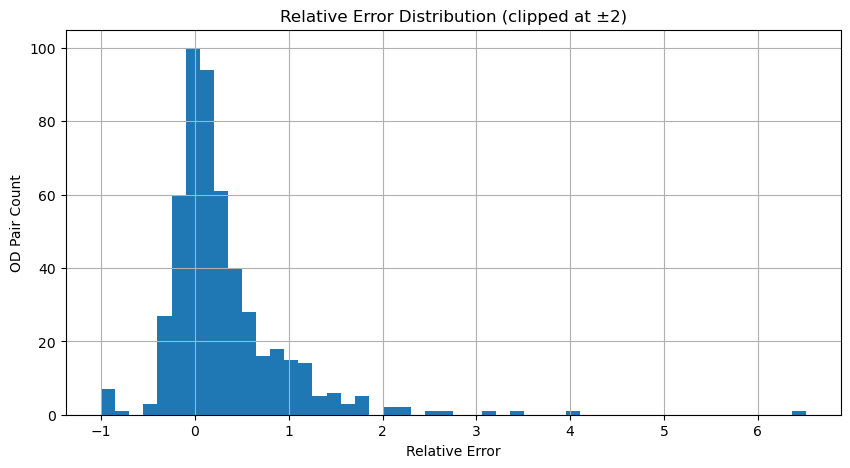

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
od_compare[od_compare['real_volume']>100]['rel_error'].dropna().clip(-2, 10).hist(bins=50)
plt.title('Relative Error Distribution (clipped at ±2)')
plt.xlabel('Relative Error')
plt.ylabel('OD Pair Count')
plt.grid(True)
plt.show()

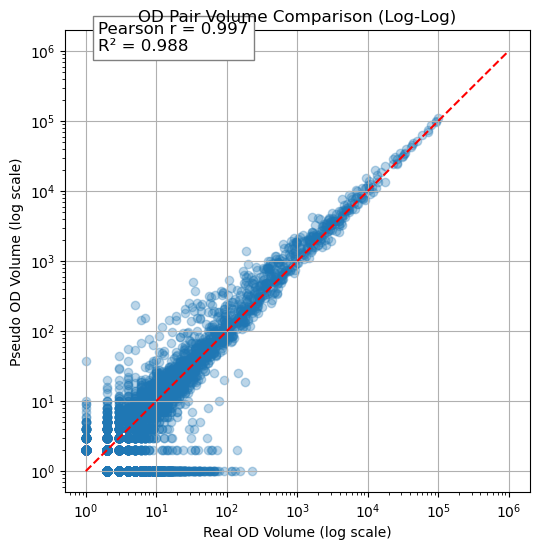

In [76]:
valid = od_compare[(od_compare['real_volume'] > 0) & (od_compare['pseudo_volume'] > 0)]
r2 = r2_score(valid['real_volume'], valid['pseudo_volume'])

valid = od_compare[(od_compare['real_volume'] > 0) & (od_compare['pseudo_volume'] > 0)]
r, p_value = pearsonr(valid['real_volume'], valid['pseudo_volume'])


plt.figure(figsize=(6, 6))
plt.scatter(
    od_compare['real_volume'] + 1,
    od_compare['pseudo_volume'] + 1,
    alpha=0.3
)
plt.xscale('log')
plt.yscale('log')
plt.plot([1, 1e6], [1, 1e6], 'r--')  # y = x line
plt.text(1.5, 1e6, f'Pearson r = {r:.3f}\nR² = {r2:.3f}', fontsize=12,
         bbox=dict(facecolor='white', edgecolor='gray'))
plt.xlabel('Real OD Volume (log scale)')
plt.ylabel('Pseudo OD Volume (log scale)')
plt.title('OD Pair Volume Comparison (Log-Log)')
plt.grid(True)
plt.show()

In [80]:
od_compare[(od_compare['real_volume']>20)&(od_compare['pseudo_volume']<2)]

,city1,city2,pseudo_volume,real_volume,diff,abs_diff,rel_error
60,22101,13101,0.0,152.0,-152.0,152.0,-1.000000
61,22101,13102,0.0,72.0,-72.0,72.0,-1.000000
62,22101,13103,0.0,114.0,-114.0,114.0,-1.000000
63,22101,13104,0.0,58.0,-58.0,58.0,-1.000000
64,22101,13105,0.0,26.0,-26.0,26.0,-1.000000
...,...,...,...,...,...,...,...
6135,22214,23106,0.0,22.0,-22.0,22.0,-1.000000
6690,22216,23106,1.0,23.0,-22.0,22.0,-0.956522
7046,22220,23211,0.0,25.0,-25.0,25.0,-1.000000
7762,22225,13101,1.0,58.0,-57.0,57.0,-0.982759


In [98]:
od_compare['pseudo_volume'].sum() / od_compare['real_volume'].sum()

1.102943740137129

In [88]:
def extract_pref_code(city_code):
    if isinstance(city_code, str):
        if len(city_code) == 5:
            return city_code[:2]
        elif len(city_code) == 4:
            return city_code[:1]
    return None

# 统一数据类型
pseudo_od['city1'] = pseudo_od['city1'].astype(str)
pseudo_od['city2'] = pseudo_od['city2'].astype(str)
real_od['city1'] = real_od['city1'].astype(str)
real_od['city2'] = real_od['city2'].astype(str)

# 提取都道府県コード
pseudo_od['to_pref'] = pseudo_od['city2'].apply(extract_pref_code)
real_od['to_pref'] = real_od['city2'].apply(extract_pref_code)

# 过滤静岡県発（city1 以 '22' 开头 且长度为5）
pseudo_shizuoka = pseudo_od[(pseudo_od['city1'].str.startswith('22')) & (pseudo_od['city1'].str.len() == 5)]
real_shizuoka = real_od[(real_od['city1'].str.startswith('22')) & (real_od['city1'].str.len() == 5)]

# 集計 by destination prefecture
pseudo_pref_dist = pseudo_shizuoka.groupby('to_pref')['pseudo_volume'].sum()
real_pref_dist = real_shizuoka.groupby('to_pref')['real_volume'].sum()

# 合并并归一化为百分比
compare_pref_dist = pd.concat([pseudo_pref_dist, real_pref_dist], axis=1, sort=True).fillna(0)
compare_pref_dist.columns = ['pseudo_volume', 'real_volume']

compare_pref_dist['pseudo_pct'] = compare_pref_dist['pseudo_volume'] / compare_pref_dist['pseudo_volume'].sum()
compare_pref_dist['real_pct'] = compare_pref_dist['real_volume'] / compare_pref_dist['real_volume'].sum()
compare_pref_dist['diff_pct'] = compare_pref_dist['pseudo_pct'] - compare_pref_dist['real_pct']
compare_pref_dist['abs_diff'] = compare_pref_dist['diff_pct'].abs()

# 百分比结果转为百分数格式便于读
compare_pref_dist_pct = compare_pref_dist.copy()
compare_pref_dist_pct[['pseudo_pct', 'real_pct', 'diff_pct']] *= 100

# 排序展示最大的差异
compare_pref_dist_pct = compare_pref_dist_pct.sort_values('abs_diff', ascending=False)


C:\Users\cyoudai\AppData\Local\Temp\2\ipykernel_6628\2883742190.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pseudo_od['city1'] = pseudo_od['city1'].astype(str)
C:\Users\cyoudai\AppData\Local\Temp\2\ipykernel_6628\2883742190.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pseudo_od['city2'] = pseudo_od['city2'].astype(str)
C:\Users\cyoudai\AppData\Local\Temp\2\ipykernel_6628\2883742190.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

<Axes: title={'center': 'Shizuoka-Origin OD by Destination Prefecture (%)'}, xlabel='to_pref'>

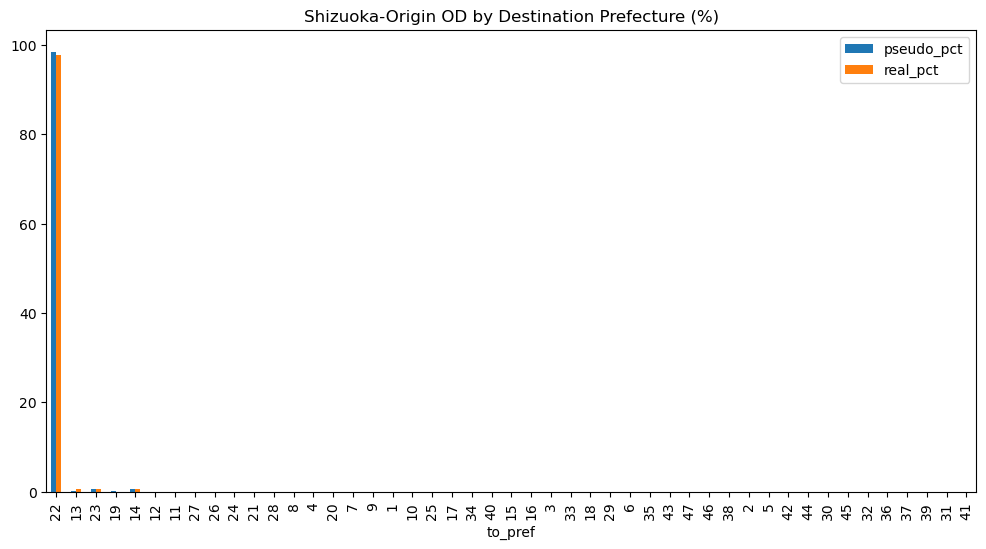

In [89]:
compare_pref_dist_pct[['pseudo_pct', 'real_pct']].plot(kind='bar', figsize=(12,6), title='Shizuoka-Origin OD by Destination Prefecture (%)')

<Axes: title={'center': 'Shizuoka-Origin OD by Destination Prefecture (%)'}, xlabel='to_pref'>

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

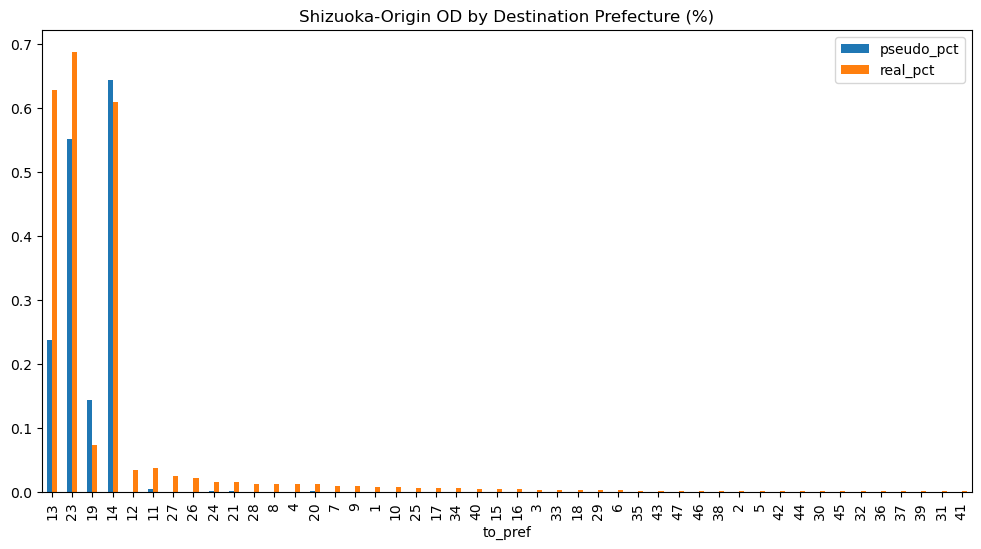

In [103]:
compare_pref_dist_pct[compare_pref_dist_pct['pseudo_pct']<90][['pseudo_pct', 'real_pct']].plot(kind='bar', figsize=(12,6), title='Shizuoka-Origin OD by Destination Prefecture (%)')

In [91]:
compare_pref_dist_pct[['pseudo_pct', 'real_pct']]

,pseudo_pct,real_pct
to_pref,,
22,98.415798,97.704512
13,0.237316,0.628546
23,0.551325,0.688070
19,0.143902,0.072814
14,0.644053,0.609951
12,0.000367,0.034462
11,0.004261,0.037594
27,0.000000,0.024861
26,0.000000,0.021374


In [92]:
# 从 pseudo_od 和 real_od 中分别筛选静岡発的记录
pseudo_shizuoka = pseudo_od[(pseudo_od['city1'].str.startswith('22')) & (pseudo_od['city1'].str.len() == 5)]
real_shizuoka = real_od[(real_od['city1'].str.startswith('22')) & (real_od['city1'].str.len() == 5)]

# 统计 pseudo 中市内 vs 市外
pseudo_within = pseudo_shizuoka[pseudo_shizuoka['city1'] == pseudo_shizuoka['city2']]['pseudo_volume'].sum()
pseudo_total = pseudo_shizuoka['pseudo_volume'].sum()
pseudo_ratio = pseudo_within / pseudo_total

# 统计 real 中市内 vs 市外
real_within = real_shizuoka[real_shizuoka['city1'] == real_shizuoka['city2']]['real_volume'].sum()
real_total = real_shizuoka['real_volume'].sum()
real_ratio = real_within / real_total

# 输出结果
print(f"【Pseudo】市内移動占比: {pseudo_ratio:.2%}（{pseudo_within:.0f}/{pseudo_total:.0f}）")
print(f"【Real】  市内移動占比: {real_ratio:.2%}（{real_within:.0f}/{real_total:.0f}）")

【Pseudo】市内移動占比: 59.46%（1297790/2182740）
【Real】  市内移動占比: 62.63%（1239440/1979013）


In [93]:
# 假设 pseudo_od 和 real_od 已经读取
pseudo_od['city1'] = pseudo_od['city1'].astype(str)
pseudo_od['city2'] = pseudo_od['city2'].astype(str)
real_od['city1'] = real_od['city1'].astype(str)
real_od['city2'] = real_od['city2'].astype(str)

# 过滤静岡発记录
pseudo_shizuoka = pseudo_od[(pseudo_od['city1'].str.startswith('22')) & (pseudo_od['city1'].str.len() == 5)].copy()
real_shizuoka = real_od[(real_od['city1'].str.startswith('22')) & (real_od['city1'].str.len() == 5)].copy()

# 分类函数：市内 / 静岡県内の他市町村 / 県外
def classify_od(row):
    c1, c2 = row['city1'], row['city2']
    if c1 == c2:
        return '市内'
    elif c2.startswith('22') and len(c2) == 5:
        return '県内市町村間'
    else:
        return '県外'

# 添加分类列
pseudo_shizuoka['category'] = pseudo_shizuoka.apply(classify_od, axis=1)
real_shizuoka['category'] = real_shizuoka.apply(classify_od, axis=1)

# 分组汇总
pseudo_stat = pseudo_shizuoka.groupby('category')['pseudo_volume'].sum()
real_stat = real_shizuoka.groupby('category')['real_volume'].sum()

# 合并、百分比计算
df_stat = pd.concat([pseudo_stat, real_stat], axis=1).fillna(0)
df_stat.columns = ['pseudo_volume', 'real_volume']
df_stat['pseudo_pct'] = df_stat['pseudo_volume'] / df_stat['pseudo_volume'].sum() * 100
df_stat['real_pct'] = df_stat['real_volume'] / df_stat['real_volume'].sum() * 100

# 排序 & 清晰展示
df_stat = df_stat.reset_index()
df_stat = df_stat[['category', 'pseudo_volume', 'pseudo_pct', 'real_volume', 'real_pct']]
df_stat = df_stat.sort_values('category')

# 打印结果
print("📊 静岡県発 OD分類比較（市内／県内市町村間／県外）")
print(df_stat.to_string(index=False, formatters={
    'pseudo_pct': '{:.2f}%'.format,
    'real_pct': '{:.2f}%'.format
}))

📊 静岡県発 OD分類比較（市内／県内市町村間／県外）
category  pseudo_volume pseudo_pct  real_volume real_pct
      市内        1297790     59.46%      1239440   62.63%
  県内市町村間         850371     38.96%       694145   35.08%
      県外          34579      1.58%        45428    2.30%


C:\Users\cyoudai\AppData\Local\Temp\2\ipykernel_6628\4227070450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pseudo_od['city1'] = pseudo_od['city1'].astype(str)
C:\Users\cyoudai\AppData\Local\Temp\2\ipykernel_6628\4227070450.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pseudo_od['city2'] = pseudo_od['city2'].astype(str)
C:\Users\cyoudai\AppData\Local\Temp\2\ipykernel_6628\4227070450.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

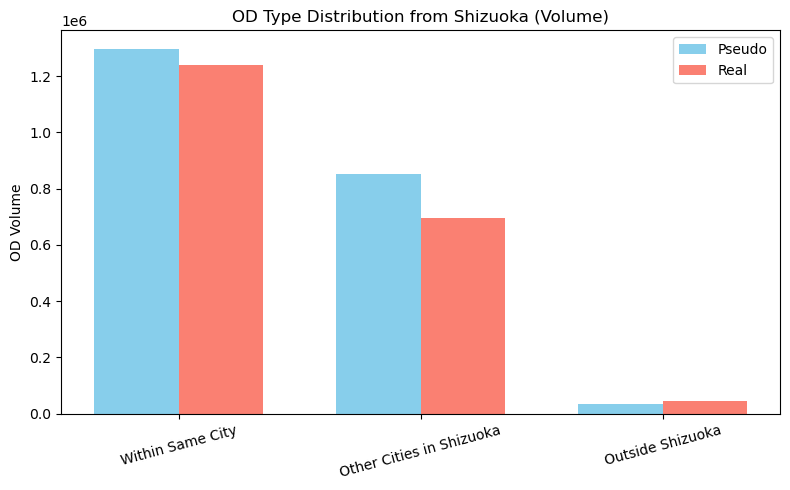

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

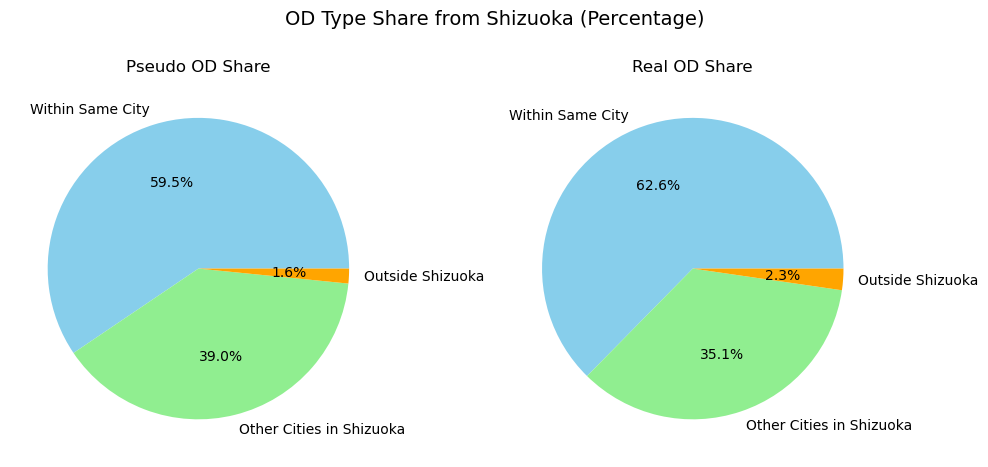

In [96]:
# 确保图表中使用英语
category_map = {
    '市内': 'Within Same City',
    '県内市町村間': 'Other Cities in Shizuoka',
    '県外': 'Outside Shizuoka'
}

df_stat['category_en'] = df_stat['category'].map(category_map)

# Bar chart: volume comparison
plt.figure(figsize=(8, 5))
bar_width = 0.35
x = range(len(df_stat))

plt.bar(x, df_stat['pseudo_volume'], width=bar_width, label='Pseudo', color='skyblue')
plt.bar([i + bar_width for i in x], df_stat['real_volume'], width=bar_width, label='Real', color='salmon')

plt.xticks([i + bar_width / 2 for i in x], df_stat['category_en'], rotation=15)
plt.ylabel('OD Volume')
plt.title('OD Type Distribution from Shizuoka (Volume)')
plt.legend()
plt.tight_layout()
plt.show()

# Pie chart: share comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Pseudo
axs[0].pie(df_stat['pseudo_pct'], labels=df_stat['category_en'], autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'orange'])
axs[0].set_title('Pseudo OD Share')

# Real
axs[1].pie(df_stat['real_pct'], labels=df_stat['category_en'], autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'orange'])
axs[1].set_title('Real OD Share')

plt.suptitle('OD Type Share from Shizuoka (Percentage)', fontsize=14)
plt.tight_layout()
plt.show()

In [84]:
pseudo_od

,city1,city2,pseudo_volume
1454,22101,14203,22
1455,22101,14206,16
1456,22101,14211,18
1457,22101,14212,1
1458,22101,14214,4
...,...,...,...
4602,22461,23234,1
4603,22461,23236,1
4604,22461,23238,3
4605,22461,23446,2


In [22]:
# root = '/mnt/large/data/PseudoPFLOW/ver2.0/trip/22/'
root = "C:/Data/PseudoPFLOW/trip/22/"
shizuoka = []

for filename in os.listdir(root):
    df = pd.read_csv(root+filename, names=['pid', 'time', 'origin_lon', 'origin_lat', 'destn_lon', 'destn_lat', 'transport', 'puropse', 'occupation'])
    shizuoka.append(df)
    
shizuoka = pd.concat(shizuoka, axis=0)
shizuoka

trip_22101.csv
trip_22102.csv
trip_22103.csv
trip_22131.csv
trip_22132.csv
trip_22133.csv
trip_22134.csv
trip_22135.csv
trip_22136.csv
trip_22137.csv
trip_22203.csv
trip_22205.csv
trip_22206.csv
trip_22207.csv
trip_22208.csv
trip_22209.csv
trip_22210.csv
trip_22211.csv
trip_22212.csv
trip_22213.csv
trip_22214.csv
trip_22215.csv
trip_22216.csv
trip_22219.csv
trip_22220.csv
trip_22221.csv
trip_22222.csv
trip_22223.csv
trip_22224.csv
trip_22225.csv
trip_22226.csv
trip_22301.csv
trip_22302.csv
trip_22304.csv
trip_22305.csv
trip_22306.csv
trip_22325.csv
trip_22341.csv
trip_22342.csv
trip_22344.csv
trip_22424.csv
trip_22429.csv
trip_22461.csv


,pid,time,origin_lon,origin_lat,destn_lon,destn_lat,transport,puropse,occupation
0,66218309,19649,138.416206,35.001436,138.528819,35.055189,2,3,21
1,66218309,24855,138.528819,35.055189,138.532404,35.058117,1,400,21
2,66218309,24060,138.532404,35.058117,138.424571,35.007414,3,2,21
3,66218309,78118,138.424571,35.007414,138.416206,35.001436,3,1,21
4,66218313,27428,138.410979,35.003842,138.411279,34.980186,3,2,21
...,...,...,...,...,...,...,...,...,...
52739,69852401,59185,137.932059,34.833128,137.810161,34.842571,3,400,15
52740,69852401,60085,137.810161,34.842571,137.932059,34.833128,3,1,15
52741,69852414,25392,137.932779,34.834391,137.891280,34.824951,3,3,11
52742,69852414,36336,137.891280,34.824951,138.013742,34.770102,1,2,11


In [23]:
shizuoka = shizuoka[(shizuoka['puropse']==2)|(shizuoka['puropse']==3)]
shizuoka

,pid,time,origin_lon,origin_lat,destn_lon,destn_lat,transport,puropse,occupation
0,66218309,19649,138.416206,35.001436,138.528819,35.055189,2,3,21
2,66218309,24060,138.532404,35.058117,138.424571,35.007414,3,2,21
4,66218313,27428,138.410979,35.003842,138.411279,34.980186,3,2,21
9,66218317,24088,138.413371,35.003699,138.390789,34.974043,1,2,21
10,66218322,23761,138.413371,35.003699,138.394062,34.981854,3,2,21
...,...,...,...,...,...,...,...,...,...
52733,69852401,18004,137.932059,34.833128,137.931085,34.831401,1,3,15
52734,69852401,18162,137.931085,34.831401,138.440889,35.002206,4,3,15
52735,69852401,23819,138.440889,35.002206,138.426185,35.013569,1,3,15
52741,69852414,25392,137.932779,34.834391,137.891280,34.824951,3,3,11


In [24]:
gdf_pref = gpd.read_file('prefectures.geojson')

gdf_origin = gpd.GeoDataFrame(
    shizuoka,
    geometry=gpd.points_from_xy(shizuoka['origin_lon'], shizuoka['origin_lat']),
    crs=gdf_pref.crs
)

gdf_dest = gpd.GeoDataFrame(
    shizuoka,
    geometry=gpd.points_from_xy(shizuoka['destn_lon'], shizuoka['destn_lat']),
    crs=gdf_pref.crs
)

gdf_origin = gpd.sjoin(gdf_origin, gdf_pref[['geometry', 'name']], how='left', predicate='within')
gdf_origin.rename(columns={'name': 'origin_pref'}, inplace=True)

gdf_dest = gpd.sjoin(gdf_dest, gdf_pref[['geometry', 'name']], how='left', predicate='within')
gdf_dest.rename(columns={'name': 'destn_pref'}, inplace=True)

shizuoka['origin_pref'] = gdf_origin['origin_pref']
shizuoka['destn_pref'] = gdf_dest['destn_pref']

od_pref_counts = shizuoka.groupby(['origin_pref', 'destn_pref']).size().reset_index(name='count')

C:\Users\cyoudai\AppData\Local\Temp\2\ipykernel_6628\1406875608.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shizuoka['origin_pref'] = gdf_origin['origin_pref']
C:\Users\cyoudai\AppData\Local\Temp\2\ipykernel_6628\1406875608.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shizuoka['destn_pref'] = gdf_dest['destn_pref']


In [25]:
od_pref_counts

,origin_pref,destn_pref,count
0,三重県,三重県,5
1,三重県,愛知県,2
2,千葉県,千葉県,9
3,千葉県,東京都,8
4,千葉県,神奈川県,1
5,埼玉県,千葉県,1
6,埼玉県,埼玉県,46
7,埼玉県,東京都,32
8,山梨県,埼玉県,1
9,山梨県,山梨県,1214


In [29]:
!pip install ace-tools

In [30]:
import ace_tools as tools; tools.display_dataframe_to_user(name="Prefecture OD分布", dataframe=od_pref_counts)

ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
shizuoka